In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#activation Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

In [3]:
#loss fnctions
def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def mean_squared_error_derivative(y_true, y_pred):
    return 2 * (y_pred - y_true) / y_true.size

# Binary Cross-Entropy binary classification (XOR)
def binary_cross_entropy(y_true, y_pred):
    # log(0) error hanling
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def binary_cross_entropy_derivative(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return ((1 - y_true) / (1 - y_pred) - y_true / y_pred) / y_true.size

In [4]:
# network and training
class MLP:
    def __init__(self, input_size, hidden_size, output_size, activation_fn_name, loss_fn_name):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

        self.activation_fn, self.activation_derivative_fn = self.get_activation_functions(activation_fn_name)
        self.loss_fn, self.loss_derivative_fn = self.get_loss_functions(loss_fn_name)

    def get_activation_functions(self, name):
        if name == 'sigmoid':
            return sigmoid, sigmoid_derivative
        elif name == 'relu':
            return relu, relu_derivative
        else:
            raise ValueError("Unsupported activation function")

    def get_loss_functions(self, name):
        if name == 'mse':
            return mean_squared_error, mean_squared_error_derivative
        elif name == 'cross_entropy':
            return binary_cross_entropy, binary_cross_entropy_derivative
        else:
            raise ValueError("Unsupported loss function")

    def forward(self, X):
        # Forward pass
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.activation_fn(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2) # Output layer typically uses sigmoid for binary classification
        return self.a2

    def backward(self, X, y_true, y_pred):
        # Backward pass
        #Calculatng the gradient of the loss with respect to the output layer output (a2)
        d_loss = self.loss_derivative_fn(y_true, y_pred)
        
        # 2. Calculatng the gradient of the loss with respect to the output layer pre-activation (z2)
        d_z2 = d_loss * sigmoid_derivative(self.a2)

        # 3. Calculatng gradients for the output layer weights (W2) and biases (b2)
        d_W2 = np.dot(self.a1.T, d_z2)
        d_b2 = np.sum(d_z2, axis=0, keepdims=True)

        # 4. Calculatng the gradient of the loss with respect to the hidden layer pre-activation (z1)
        d_a1 = np.dot(d_z2, self.W2.T)
        d_z1 = d_a1 * self.activation_derivative_fn(self.a1)

        # 5. Calculatng gradients for the hidden layer weights (W1) and biases (b1)
        d_W1 = np.dot(X.T, d_z1)
        d_b1 = np.sum(d_z1, axis=0, keepdims=True)

        return d_W1, d_b1, d_W2, d_b2

    def train(self, X, y, epochs, learning_rate):
        loss_history = []
        for i in range(epochs):
            y_pred = self.forward(X)
            loss = self.loss_fn(y, y_pred)
            loss_history.append(loss)

            d_W1, d_b1, d_W2, d_b2 = self.backward(X, y, y_pred)

            # Update weights and biases
            self.W1 -= learning_rate * d_W1
            self.b1 -= learning_rate * d_b1
            self.W2 -= learning_rate * d_W2
            self.b2 -= learning_rate * d_b2

            if (i+1) % 100 == 0:
                print(f"Epoch {i+1}, Loss: {loss:.4f}")
        return loss_history
#Numerical Gradient Check
def numerical_gradient_check(model, X, y, epsilon=1e-5):
    # analytical gradients
    y_pred = model.forward(X)
    grad_W1, grad_b1, grad_W2, grad_b2 = model.backward(X, y, y_pred)

    # Check W1
    for i in range(model.W1.shape[0]):
        for j in range(model.W1.shape[1]):
            # Plus epsilon
            model.W1[i, j] += epsilon
            loss1 = model.loss_fn(y, model.forward(X))
            # Minus epsilon
            model.W1[i, j] -= 2 * epsilon
            loss2 = model.loss_fn(y, model.forward(X))
            # Restore original value
            model.W1[i, j] += epsilon

            numerical_grad = (loss1 - loss2) / (2 * epsilon)
            backprop_grad = grad_W1[i, j]
            
            relative_diff = np.abs(numerical_grad - backprop_grad) / (np.abs(numerical_grad) + np.abs(backprop_grad))
            
            # Print the difference for your report. A small value is good.
            print(f"W1[{i}, {j}] Relative Diff: {relative_diff:.10f}")



Epoch 100, Loss: 0.6931
Epoch 200, Loss: 0.6929
Epoch 300, Loss: 0.6923
Epoch 400, Loss: 0.6894
Epoch 500, Loss: 0.6773
Epoch 600, Loss: 0.6322
Epoch 700, Loss: 0.5230
Epoch 800, Loss: 0.4033
Epoch 900, Loss: 0.3536
Epoch 1000, Loss: 0.3489
Epoch 1100, Loss: 0.3585
Epoch 1200, Loss: 0.3471
Epoch 1300, Loss: 0.3468
Epoch 1400, Loss: 0.3466
Epoch 1500, Loss: 0.5460
Epoch 1600, Loss: 0.3467


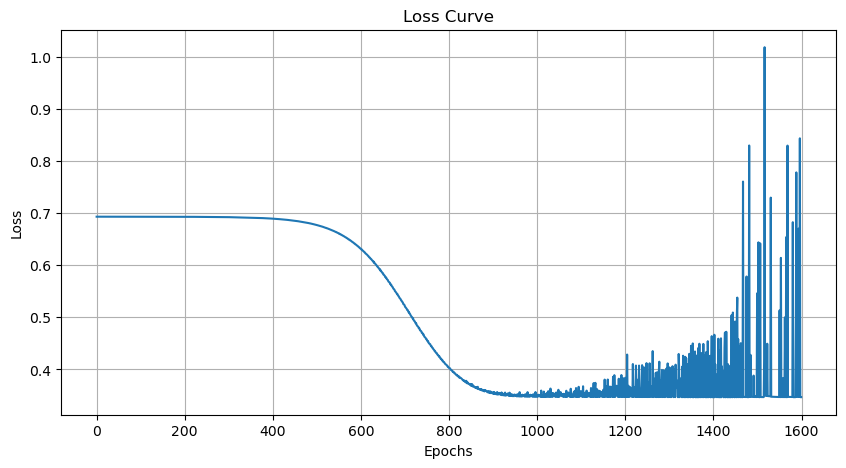


--- Running Numerical Gradient Check ---
W1[0, 0] Relative Diff: nan
W1[0, 1] Relative Diff: 1.0000000000
W1[0, 2] Relative Diff: 1.0000000000
W1[0, 3] Relative Diff: nan
W1[1, 0] Relative Diff: nan
W1[1, 1] Relative Diff: 1.0000000000
W1[1, 2] Relative Diff: 1.0000000000
W1[1, 3] Relative Diff: 1.0000000000
--- Gradient check complete ---


C:\Users\iamsp\AppData\Local\Temp\ipykernel_15260\3348901088.py:98: RuntimeWarning: invalid value encountered in scalar divide
  relative_diff = np.abs(numerical_grad - backprop_grad) / (np.abs(numerical_grad) + np.abs(backprop_grad))
C:\Users\iamsp\AppData\Local\Temp\ipykernel_15260\546347321.py:3: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


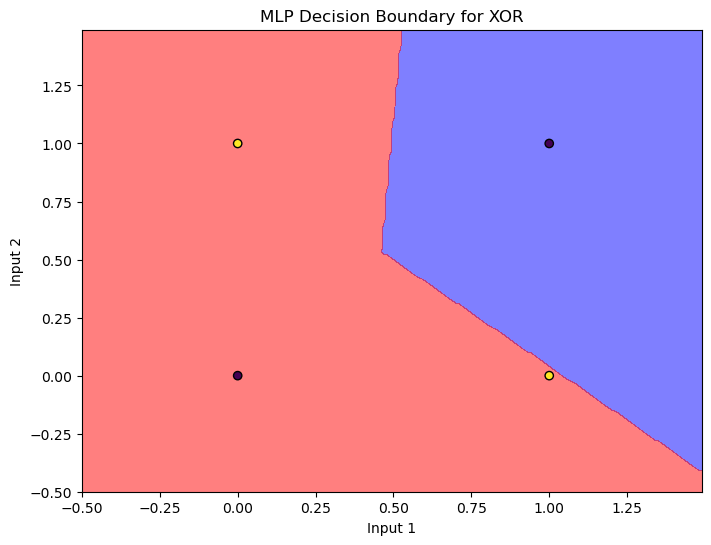

In [6]:
#execution and plotting
if __name__ == '__main__':
    # Define XOR dataset
    X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
    y = np.array([[0], [1], [1], [0]])

    # Model parameters
    input_size = 2
    hidden_size = 4
    output_size = 1
    learning_rate = 0.1
    epochs = 1600

    # Initialize and train the network
    mlp = MLP(input_size, hidden_size, output_size, 'relu', 'cross_entropy')
    loss_history = mlp.train(X, y, epochs, learning_rate)

    # Plotting Loss Curve
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(loss_history)), loss_history)
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # Numerical Gradient Check
    print("\n--- Running Numerical Gradient Check ---")
    numerical_gradient_check(mlp, X, y)
    print("--- Gradient check complete ---")

    # Plotting Decision Boundary
    plt.figure(figsize=(8, 6))
    plt.title("MLP Decision Boundary for XOR")
    x_min, x_max = -0.5, 1.5
    y_min, y_max = -0.5, 1.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = mlp.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, levels=[-0.1, 0.5, 1.1], colors=['blue', 'red'], alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k')
    plt.xlabel("Input 1")
    plt.ylabel("Input 2")
    plt.show()